Imports Required for LangGraph and Tools

In [1]:
from typing import TypedDict, List, Dict, Any, Annotated, Sequence, Optional
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, FunctionMessage
from langchain_openai import ChatOpenAI
from langgraph.graph import END, StateGraph
from langchain.tools import tool
import requests
import urllib.parse
import json
import os
from dotenv import load_dotenv

Load the Environment Variables.

In [2]:

# Load environment variables
load_dotenv()

True

****RAG Agent for FDA Regulatory Topics for SAMD****
Next we will build a RAG Agent!

In [3]:
# Import required libraries
from langchain.document_loaders import PyMuPDFLoader
from langchain.schema import Document
import os
from typing import List

def read_pdf_documents(docs_dir: str = "docs") -> List[Document]:
    """
    Read PDF documents from the specified directory returning a list of documents.
    
    Args:
        docs_dir (str): Path to directory containing PDF documents
        
    Returns:
        List[str]: List of extracted text content from PDFs
    """
    documents = []
    
    # Iterate through files in docs directory
    for filename in os.listdir(docs_dir):
        if filename.endswith(".pdf"):
            pdf_path = os.path.join(docs_dir, filename)
            
            try:
                temp_doc = PyMuPDFLoader(pdf_path).load()
                documents.extend(temp_doc)
                print(f"Loaded doc: {filename}")
                
            except Exception as e:
                print(f"Error reading {filename}: {str(e)}")
                
    return documents

# Read PDF documents
pdf_documents = read_pdf_documents()



Loaded doc: imdrf-tech-151002-samd-qms.pdf
Loaded doc: s41746-024-01270-x.pdf
Loaded doc: imdrf-tech-131209-samd-key-definitions-140901.pdf
Loaded doc: Guidance-Predetermined-Change-Control-Plans.pdf
Loaded doc: Premarket-Software-Functions-Guidance.pdf


Now we Chunk the docs

In [4]:
import tiktoken
from langchain.text_splitter import RecursiveCharacterTextSplitter

def tiktoken_len(text):
    tokens = tiktoken.encoding_for_model("gpt-4o-mini").encode(
        text,
    )
    return len(tokens)

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 800,
    chunk_overlap = 0,
    length_function = tiktoken_len,
)

docs = read_pdf_documents()
split_chunks = text_splitter.split_documents(docs)

Loaded doc: imdrf-tech-151002-samd-qms.pdf
Loaded doc: s41746-024-01270-x.pdf
Loaded doc: imdrf-tech-131209-samd-key-definitions-140901.pdf
Loaded doc: Guidance-Predetermined-Change-Control-Plans.pdf
Loaded doc: Premarket-Software-Functions-Guidance.pdf


In [5]:
len(split_chunks)

172

Now we create out Embedding Model

In [6]:
from langchain_openai.embeddings import OpenAIEmbeddings

embedding_model = OpenAIEmbeddings(model="text-embedding-3-large")

Now we can create our QDrant backed vector store!

In [7]:
from langchain_community.vectorstores import Qdrant

qdrant_vectorstore = Qdrant.from_documents(
    split_chunks,
    embedding_model,
    location=":memory:",
    collection_name="fda_guidance_for_samd_and_aiml",
)

Let us create a retriver to access this

In [8]:
qdrant_retriever = qdrant_vectorstore.as_retriever()

Now we will create a RAG Prompt

In [9]:
from langchain_core.prompts import ChatPromptTemplate

RAG_PROMPT = """
CONTEXT:
{context}

QUERY:
{question}

You are a helpful FDA Auditor. Use the available context to answer the question. If you can't answer the question, say you don't know.
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_PROMPT)

Let us put the G in RAG

In [10]:
from langchain_openai import ChatOpenAI

openai_chat_model = ChatOpenAI(model="gpt-4o-mini")

Lastly we combine our R,A and G into an LCEL Chain!

In [11]:
from operator import itemgetter
from langchain.schema.output_parser import StrOutputParser

rag_chain = (
    {"context": itemgetter("question") | qdrant_retriever, "question": itemgetter("question")}
    | rag_prompt | openai_chat_model | StrOutputParser()
)

Let us test this and make sure that it works.

In [12]:
rag_chain.invoke({"question" : "Do i need a new 510K submission each time i make a modification to my machine learning model?"})

'Yes, you may need a new 510(k) submission if the modification to your machine learning model constitutes a significant change that could affect the safety or effectiveness of the device. However, if the modification is planned and falls under a predetermined change control plan (PCCP) that has been authorized, you may not need to submit a new 510(k) for each modification.\n\nAccording to the guidance, significant changes or modifications that require a 510(k) include changes in design, material, chemical composition, energy source, or manufacturing process that could significantly affect the device. Therefore, it is recommended to conduct a risk-based assessment to determine if the modification requires a new marketing submission. If the modification is included in an authorized PCCP, then it can be made without a new submission, provided the device remains safe and effective as originally cleared.'

Let us now create a RAG tool to be used in a LangGraph Agent Node.

In [13]:
from typing import Annotated, List, Tuple, Union
from langchain_core.tools import tool

@tool
def retrieve_fda_information(
    query: Annotated[str, "query to ask the retrieve information tool"]
    ):
    """You are an FDA Regulatory expert who can provide information on the following regulatory topics:
    1. AI and ML topics related to software as a medical device 
    2. Premarket software functions guidance
    3. Quality Management (QMS) systems 
    4. Reporting gaps in FDA-approved AI medical devices
    """
    return rag_chain.invoke({"question": query})

****Cybersecurity RAG Agent****

We now create another RAG Agent for Cybersecurity Requirements

First we will load and Split the documents

In [14]:
pdf_documents = read_pdf_documents(docs_dir="docs/cybersecurity")
cyber_security_split_chunks = text_splitter.split_documents(pdf_documents)
len(cyber_security_split_chunks)          

Loaded doc: Guidance-Device-Cybersecurity-Premarket.pdf
Loaded doc: 2303.03140v1.pdf
Loaded doc: Postmarket-Management-of-Cybersecurity-in-Medical-Devices---Guidance-for-Industry-and-Food-and-Drug-Administration-Staff.pdf


132

We create an Embedding Model for the CyberSecurity documents

In [15]:
embedding_model = OpenAIEmbeddings(model="text-embedding-3-large")

Then we create a QDrant Datatore on disk

In [16]:

cyber_security_qdrant_vectorstore = Qdrant.from_documents(
    cyber_security_split_chunks,
    embedding_model,
    location=":memory:",  # Local path where data will be stored
    collection_name="cybersecurity_requirements",
)

Next we create a retriever

In [17]:
cyber_security_qdrant_retriever = qdrant_vectorstore.as_retriever()

Let us construct a RAG Prompt

In [18]:
RAG_PROMPT = """
CONTEXT:
{context}

QUERY:
{question}

You are a helpful Cybersecurity Expert in the field of FDA Software as a Medical Device. Use the available context to answer the question. 
If you can't answer the question, say you don't know.
"""

cyber_security_rag_prompt = ChatPromptTemplate.from_template(RAG_PROMPT)

Now we'll create a Generation model

In [19]:

cyber_security_openai_chat_model = ChatOpenAI(model="gpt-4o-mini")

Lastly we will create an LCEL RAG Chain for Cybersecurity

In [20]:
cyber_security_rag_chain = (
    {"context": itemgetter("question") | cyber_security_qdrant_retriever, "question": itemgetter("question")}
    | cyber_security_rag_prompt | cyber_security_openai_chat_model | StrOutputParser()
)

Let us test this chain

In [21]:
cyber_security_rag_chain.invoke({"question" : "How do you ensure that cybersecurity requirements are incorporated into design inputs and verified in design outputs?"})

'To ensure that cybersecurity requirements are incorporated into design inputs and verified in design outputs for Software as a Medical Device (SaMD), the following steps can be taken:\n\n1. **Incorporate Cybersecurity into Design Inputs**:\n   - Identify cybersecurity requirements early in the design process, based on user needs, intended use, and applicable regulations. This should include considerations for maintaining patient safety, confidentiality, availability, and integrity of critical functions and data.\n   - Analyze potential security threats and vulnerabilities during the requirements phase, considering the operational environment where the SaMD will be used (e.g., home, hospital, clinic). This includes assessing clinical hazards that might impact design.\n   - Document these cybersecurity requirements in software requirements specifications (SRS), ensuring that they are part of the overall system architecture and design considerations.\n\n2. **Verification and Validation**

Lastly we will create a RAG tool to retrieve cybersecurity information

In [22]:

@tool
def retrieve_cybersecurity_information(
    query: Annotated[str, "query to ask the retrieve information tool"]
    ):
    """You are an FDA Cybersecurity expert who can provide information on the following regulatory topics:
    1. Cybersecurity requirements for FDA submissions
    2. Cybersecurity requirements for FDA-approved AI medical devices
    3. Pre-Market Cybersecurity requirements for FDA-approved software as a medical device
    4. Post-Market Cybersecurity requirements for FDA-approved software as a medical device
    5. NIST Cybersecurity framework
    6. Risks, Legislation and Challenges in Cybersecurity for FDA-approved software as a medical device
    """
    return cyber_security_rag_chain.invoke({"question": query})

So Far we have created:

1. FDA Regulatory Submissions RAG agent who is primed to questions regarding regulatory submissions.
2. FDA Cybersecurity RAG Agent who can answer any queries regarding cybersecurity requirements for FDA submissions.
   
Time to put everything together under an Agentic Workflow

Let us first create a ***Tool Belt***

In [23]:
tool_belt = [
    retrieve_fda_information,
    retrieve_cybersecurity_information
]

Now let us setup the model and bind the tool bet to the model

In [24]:
from langchain_openai import ChatOpenAI

model = ChatOpenAI(model="gpt-4-turbo", temperature=0)

model = model.bind_tools(tool_belt)

Now we will create an Agent State

In [25]:
from typing import TypedDict, Annotated
from langgraph.graph.message import add_messages
import operator
from langchain_core.messages import BaseMessage

class AgentState(TypedDict):
  messages: Annotated[list, add_messages]

Next we will create the two nodes in the graph

In [26]:
from langgraph.prebuilt import ToolNode

def call_model(state):
  messages = state["messages"]
  response = model.invoke(messages)
  return {"messages" : [response]}

tool_node = ToolNode(tool_belt)

Then will will create the graph

In [27]:
from langgraph.graph import StateGraph, END

regulatory_framework_graph = StateGraph(AgentState)

regulatory_framework_graph.add_node("agent", call_model)
regulatory_framework_graph.add_node("action", tool_node)
regulatory_framework_graph.set_entry_point("agent")

def should_continue(state):
  last_message = state["messages"][-1]

  if last_message.tool_calls:
    return "action"

  return END

regulatory_framework_graph.add_conditional_edges(
    "agent",
    should_continue
)
regulatory_framework_graph.add_edge("action", "agent")
compiled_regulatory_framework_graph = regulatory_framework_graph.compile()

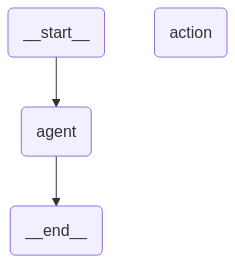

In [28]:
from IPython.display import Image, display

# Generate the PNG data
mermaid_png = compiled_regulatory_framework_graph.get_graph().draw_mermaid_png()

# Display the image properly
display(Image(data=mermaid_png))

In [29]:
from langchain_core.messages import HumanMessage

inputs = {"messages" : [HumanMessage(content="Under what circumstances is a PCCP required?")]}

async for chunk in compiled_regulatory_framework_graph.astream(inputs, stream_mode="updates"):
    for node, values in chunk.items():
        print(f"Receiving update from node: '{node}'")
        print(values["messages"])
        print("\n\n")

Receiving update from node: 'agent'
[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_gRUmhWrjVWr4kUx7CoY99zvG', 'function': {'arguments': '{"query":"PCCP requirements"}', 'name': 'retrieve_cybersecurity_information'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 268, 'total_tokens': 290, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4-turbo-2024-04-09', 'system_fingerprint': 'fp_de235176ee', 'id': 'chatcmpl-BVqPCTOQiCWLSdlas1OEiVoJ5Fy9Y', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--99994f16-847a-4cc6-a6b2-60a58e881974-0', tool_calls=[{'name': 'retrieve_cybersecurity_information', 'args': {'query': 'PCCP requirements'}, 'id': 'call_gRUmhWrjVWr4kUx7CoY99zvG', 'type': 'tool_call'}

In [30]:
inputs = {"messages" : [HumanMessage(content="Explain the QMS requirements for SAMD, how are cybersecurity requirements handled in QMS?")]}

async for chunk in compiled_regulatory_framework_graph.astream(inputs, stream_mode="updates"):
    for node, values in chunk.items():
        print(f"Receiving update from node: '{node}'")
        if node == "action":
          print(f"Tool Used: {values['messages'][0].name}")
        print(values["messages"])

        print("\n\n")

Receiving update from node: 'agent'
[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_DXciEi33PeHcMkBVUl9ytZVv', 'function': {'arguments': '{"query": "Quality Management Systems requirements for Software as a Medical Device"}', 'name': 'retrieve_fda_information'}, 'type': 'function'}, {'id': 'call_m3ueEDbV1IMm8r239lsxDHhl', 'function': {'arguments': '{"query": "Cybersecurity requirements in Quality Management Systems for FDA-approved software as a medical device"}', 'name': 'retrieve_cybersecurity_information'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 74, 'prompt_tokens': 277, 'total_tokens': 351, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4-turbo-2024-04-09', 'system_fingerprint': 'fp_de235176ee', 'id': 'chatcmpl-BVqROWmRAtvKQfVgy3